## Efficient Influence Function (EIF), DML with Continuous Treatment (Causal Forest DML), & DML with Mediator Continuous Treatment

Daniel de Abreu Pereira Uhr




**Observações:** O material apresentado aqui é uma adaptação do material de aula do Prof. Daniel de Abreu Pereira Uhr, e não deve ser utilizado para fins comerciais. O material é disponibilizado para fins educacionais e de pesquisa, e não deve ser reproduzido sem a devida autorização do autor. Este material pode conter erros e imprecisões. O autor não se responsabiliza por quaisquer danos ou prejuízos decorrentes do uso deste material. O uso deste material é de responsabilidade exclusiva do usuário. Caso você encontre erros ou imprecisões neste material, por favor, entre em contato com o autor para que possam ser corrigidos. O autor agradece qualquer *feedback* ou sugestão de melhoria.

---

### Efficient Influence Function (EIF)


A **Efficient Influence Function (EIF)** (ou **Função de Influência Eficiente**) é o **objeto matemático fundamental** que define:

1. o **estimador mais eficiente possível** de um parâmetro causal (como o ATE),
2. e as condições sob as quais esse estimador é **sem viés em primeira ordem** mesmo quando usamos ML flexível nas etapas auxiliares.

Quando queremos estimar um parâmetro causal, por exemplo o efeito médio do tratamento (ATE):

$$
\psi_0 = E[m_1(X) - m_0(X)]
$$

onde ($m_d(X) = E[Y|D=d, X]$),

temos duas fontes de incerteza:

* o erro de amostragem (ruído estatístico);
* e o erro de estimação dos “nuisance functions” (os modelos de ($E[Y|D,X]$) e ($P(D|X)$)).


**Definição**

A **Efficient Influence Function (EIF)** é uma função ($\phi(W; \psi_0)$) que mede **como o erro em cada observação influencia o erro total do estimador** de forma linearizada.

Considere o espaço de todas as distribuições ($P$) para os dados ($W=(Y,D,X)$). O parâmetro de interesse é uma função ($\psi(P)$) (por exemplo, o ATE).

A **influence function** (IF) é definida como:

$$
\phi(W; P) = \left. \frac{d}{d\epsilon} \psi(P_\epsilon) \right|_{\epsilon=0}
$$

onde ($P_\epsilon = (1 - \epsilon) P + \epsilon \delta_W$).

***Interpretação:***

É a **sensibilidade infinitesimal** do estimando ($\psi(P)$) a pequenas perturbações na distribuição amostral em torno de ($P$).

A **Efficient Influence Function (EIF)** é a **influence function com menor variância** entre todas as IFs válidas (isto é, todas que têm esperança zero e derivam corretamente ($\psi(P)$)).
Essa variância mínima define o **semiparametric efficiency bound**.

**Exemplo**

Para ($D \in {0,1}$), o EIF do ATE é:

$$
\phi(W; \eta) =
\left[
\frac{D}{p(X)} - \frac{1-D}{1-p(X)}
\right](Y - m(D,X)) + [m(1,X) - m(0,X)] - \psi
$$

onde:

* ($p(X) = P(D=1|X)$) é o propensity score,
* ($m(d,X) = E[Y|D=d, X]$) é o outcome regression,
* ($\eta = (m, p)$) é o vetor dos “nuisance parameters”.

Esse objeto é importante porque:

* ($E[\phi(W; \eta_0)] = 0$) no ponto verdadeiro;
* Ele é **ortogonal**: pequenas variações em ($m$) ou ($p$) não alteram ($\psi$) em primeira ordem;
* E ele **gera todos os estimadores eficientes** possíveis (TMLE, AIPW, DR-DML, etc).

A EIF serve como a **base de construção** de todos os estimadores modernos de efeito causal:

| Estimador                | Como usa a EIF                                                            |
| ------------------------ | ------------------------------------------------------------------------- |
| **AIPW (Augmented IPW)** | Substitui ($m, p$) por ML e usa a média de ($\phi(W; \hat\eta)$)              |
| **TMLE**                 | Ajusta ($m$) até que a média de ($\phi(W; \hat\eta^*) = 0$)                   |
| **DR-DML**               | Usa cross-fitting e estima ($\psi$) resolvendo ($E_n[\phi(W; \hat\eta)] = 0$) |
| **Causal Forests**       | Aproximam o EIF localmente em cada folha                                  |
| **G-formula**            | Implícita, sem ajuste pela EIF (por isso é menos robusta)                 |


***Propriedades***

1. **Esperança zero:**
   $$
   E[\phi(W; \eta_0)] = 0
   $$

2. **Ortogonalidade:**
   $$
   \frac{\partial E[\phi(W; \eta)]}{\partial \eta}\Big|_{\eta_0} = 0
   $$
   → pequenos erros em ML não afetam ($\hat\psi$).

3. **Variância mínima:**
   $$
   Var(\phi(W; \eta_0)) = \text{Semiparametric Efficiency Bound}
   $$

4. **Inferência assintótica:**
   $$
   \sqrt{n}(\hat\psi - \psi_0) \to N(0, Var(\phi(W; \eta_0)))
   $$
   → Intervalos de confiança vêm diretamente da EIF.

***Relação entre TMLE, DR e DML***

* **TMLE**: constrói um modelo para ($m(D,X)$) e ajusta via *targeting* até satisfazer ($E_n[\phi(W;\hat\eta)] = 0$).
* **DR-DML**: usa cross-fitting e resolve a mesma equação, mas sem targeting iterativo.
* **Ambos estimam o mesmo parâmetro** — o ATE — definido exatamente pela EIF acima.


***Interpretação intuitiva***

Pense na EIF como o **"peso ótimo"** que cada observação deve ter para corrigir viés de confusão.

* O termo ($\frac{D}{p(X)} - \frac{1-D}{1-p(X)}$) ajusta o desequilíbrio de propensão;
* O termo ($Y - m(D,X)$) corrige a predição;
* E ($m(1,X) - m(0,X)$) dá o componente contrafactual esperado.

A média ponderada desses componentes é o **efeito causal eficiente**.

### Continuous Treatment with DML



In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns

# DataFrame
df = pd.read_stata("https://github.com/Daniel-Uhr/data/raw/main/cattaneo2.dta")

In [8]:
# Criar a variável de resultado
df['Y'] = df['bweight']

# Crie a variável 'Treated' com valor inicial de 0
df['Treated'] = 0
# Recodifique 'Treated' para 1 se 'mbsmoke' for igual a 'smoker'
df.loc[df['mbsmoke'] == 'smoker', 'Treated'] = 1

df['casada'] = 0
df.loc[df['mmarried']=='married', 'casada'] = 1

# Conjunto de Covariáveis X
X = ['casada', 'mage', 'medu']

# garanta a ordem correta das categorias (se necessário)
order = ['0 daily', '1-5 daily', '6-10 daily', '11+ daily']
df['msmoke'] = pd.Categorical(df['msmoke'], categories=order, ordered=True)

# mapeamentos
map_mid = {
    '0 daily': 0,
    '1-5 daily': 3,
    '6-10 daily': 8,
    '11+ daily': 12  # ajuste se quiser um outro representativo (ex.: 15)
}
map_ord = {k: i for i, k in enumerate(order)}  # 0,1,2,3 (ordinal)

# variáveis de tratamento
df['T_cont'] = df['msmoke'].map(map_mid).astype(float) 

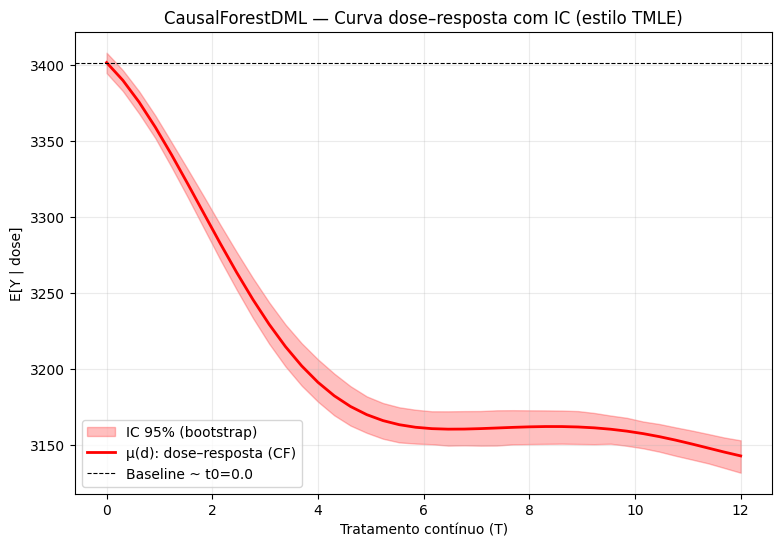

In [32]:
# ==========================================================
# CausalForestDML — Dose–resposta com IC (vermelho), "estilo TMLE"
# Nível = E[Y|t0,X] (modelo de outcome) + efeito CF (t0->t)
# Grid de 40 pts; RBF features ricas; bootstrap nas unidades X
# ==========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import make_pipeline
from sklearn.base import clone
from econml.dml import CausalForestDML

# ---------- Config ----------
RNG_SEED = 42
rng = np.random.default_rng(RNG_SEED)

# ---------- 0) Dados ----------
try:
    df
except NameError:
    df = pd.read_stata("https://github.com/Daniel-Uhr/data/raw/main/cattaneo2.dta")
    df['Y'] = df['bweight']
    df['casada'] = (df['mmarried'] == 'married').astype(int)

# Use o T_cont contínuo que você já criou (sem jitter), ou crie mapeamento midpoints
# Aqui assumo que df['T_cont'] já existe (se não, crie como no seu TMLE).
df_ = df[['Y','T_cont','casada','mage','medu']].dropna().copy()

Y = df_['Y'].to_numpy(dtype=np.float32)
T = df_['T_cont'].to_numpy(dtype=np.float32)
X = df_[['casada','mage','medu']].to_numpy(dtype=np.float32)

Xn = StandardScaler().fit_transform(X).astype(np.float32)

# ---------- 1) Featurizador em T: RBF (mais rico → curva menos "quadrática") ----------
tfeat = RBFSampler(gamma=0.08, n_components=150, random_state=RNG_SEED)

# ---------- 2) Nuisance models (um pouco mais fortes, ainda rápidos) ----------
rf_cfg = dict(
    n_estimators=120,
    max_depth=10,
    min_samples_leaf=15,
    max_features='sqrt',
    n_jobs=-1,
    random_state=RNG_SEED
)
model_y = ExtraTreesRegressor(**rf_cfg)
model_t = ExtraTreesRegressor(**rf_cfg)

# ---------- 3) CausalForestDML ----------
cf = CausalForestDML(
    model_y=model_y,
    model_t=model_t,
    treatment_featurizer=tfeat,
    discrete_treatment=False,
    n_estimators=300,
    min_samples_leaf=10,
    max_depth=8,
    random_state=RNG_SEED,
    n_jobs=-1,
    verbose=0
)
# T em 2D por causa do featurizer
cf.fit(Y, T.reshape(-1, 1), X=Xn)

# ---------- 4) Modelo de outcome para o NÍVEL E[Y|t0, X]
# Usamos a MESMA featurização de T do CF para coerência
# Feature final: concatena Xn com phi(T) (RBF transform)
Phi_T = tfeat.fit_transform(T.reshape(-1, 1))  # usa a mesma instância tfeat
Z = np.hstack([Xn, Phi_T])                     # regressão Y ~ X + phi(T)

outcome_model = clone(model_y)
outcome_model.fit(Z, Y)

def predict_y_at_t(Xblock, t_scalar):
    # constroi features [X, phi(t)] p/ cada linha de Xblock
    m = Xblock.shape[0]
    Phi = tfeat.transform(np.full((m, 1), t_scalar, dtype=np.float32))
    Zt = np.hstack([Xblock, Phi])
    return outcome_model.predict(Zt)

# ---------- 5) Curva dose–resposta + IC (bootstrap nas unidades X)
# amostra maior de X para agregação
M = min(600, len(Xn))
idx = rng.choice(len(Xn), size=M, replace=False)
Xsub = Xn[idx]

# grid de 40 doses
t_min, t_max = float(np.nanmin(T)), float(np.nanmax(T))
G = 40
t_grid = np.linspace(t_min, t_max, G).astype(np.float32)

# baseline: percentil 5% (na região com dados)
t0 = float(np.percentile(T, 5))

# 5.1) Nível no baseline por unidade: Y_hat(t0|X)
y0_hat = predict_y_at_t(Xsub, t0)  # (M,)

# 5.2) Efeito marginal CF por unidade para cada t do grid
Eff = np.empty((G, M), dtype=np.float32)
for g, t1 in enumerate(t_grid):
    T0 = np.full((M, 1), t0, dtype=np.float32)
    T1 = np.full((M, 1), t1, dtype=np.float32)
    Eff[g, :] = cf.effect(Xsub, T0=T0, T1=T1)  # τ(X; t0→t1)

# 5.3) Reconstrução do nível e média por dose
# μ(d) = mean_X [ Y_hat(t0|X) + τ(X; t0→d) ]
mu_hat = (y0_hat[None, :] + Eff).mean(axis=1)  # (G,)

# 5.4) Bootstrap das unidades X (rápido, sem refitar o CF)
B = 300
boot_mu = np.empty((B, G), dtype=np.float32)
for b in range(B):
    samp = rng.integers(0, M, size=M)  # reamostra unidades
    boot_mu[b, :] = (y0_hat[samp][None, :] + Eff[:, samp]).mean(axis=1)

alpha = 0.05
lo = np.percentile(boot_mu, 100*(alpha/2), axis=0)
hi = np.percentile(boot_mu, 100*(1-alpha/2), axis=0)

# ---------- 6) Plot (vermelho) ----------
plt.figure(figsize=(9,6))
plt.fill_between(t_grid, lo, hi, color='red', alpha=0.25, label='IC 95% (bootstrap)')
plt.plot(t_grid, mu_hat, color='red', lw=2, label='μ(d): dose–resposta (CF)')
plt.axhline(mu_hat[np.argmin(np.abs(t_grid - t0))], color='k', ls='--', lw=0.8, label=f'Baseline ~ t0={t0:.1f}')
plt.xlabel("Tratamento contínuo (T)")
plt.ylabel("E[Y | dose]")
plt.title("CausalForestDML — Curva dose–resposta com IC (estilo TMLE)")
plt.legend()
plt.grid(True, alpha=0.25)
plt.show()


c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\econml-env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\econml-env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


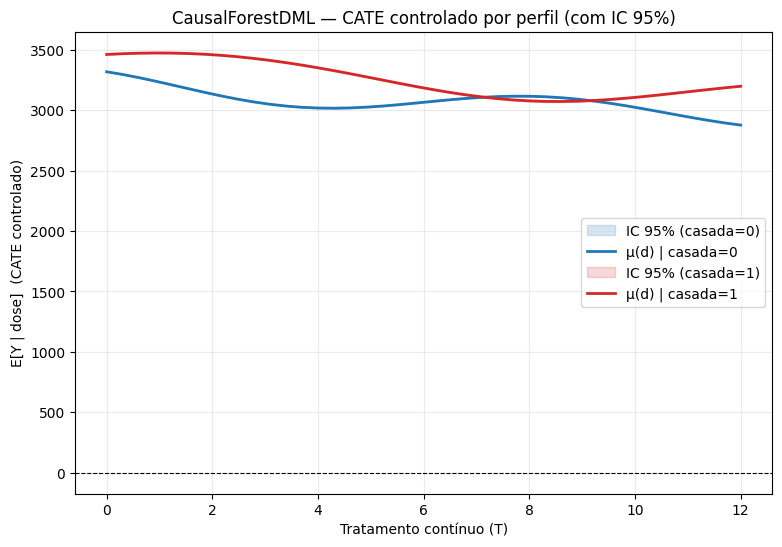

In [ ]:
# ==========================================================
# CATE controlado (por perfil) — CF + baseline outcome
# Você define como "controlar" cada covariável (mean/median/pXX/valor)
# ==========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# ----------------------------------------------------------
# 0) PRÉ-REQUISITOS (já existentes no seu fluxo anterior)
# ----------------------------------------------------------
# - df_: DataFrame usado no fit, com colunas ['casada','mage','medu', ...]
# - COLS_X: ordem das covariáveis em X (ex.: ['casada','mage','medu'])
# - scaler: StandardScaler já ajustado em df_[COLS_X]
# - cf: CausalForestDML já treinado com treatment_featurizer=tfeat
# - tfeat: mesmo featurizador de T usado no cf (RBF/Spline)
# - outcome_model: modelo de outcome treinado em [Xn, phi(T)]
# - T, t_grid (40 pts), t0 já definidos

# Se ainda não tiver o scaler salvo, refaça aqui (mesmo padrão do treino):
# scaler = StandardScaler().fit(df_[COLS_X].astype(float))

# ----------------------------------------------------------
# 1) Helpers para "especificações de controle"
# ----------------------------------------------------------
def _resolve_control_value(series: pd.Series, spec):
    """
    Converte um especificador (string ou número) em valor numérico.
      - 'mean' -> média
      - 'median' -> mediana
      - 'pXX' -> percentil XX (ex.: 'p10','p25','p90')
      - numérico -> retorna como float
    """
    if isinstance(spec, (int, float, np.number)):
        return float(spec)
    if isinstance(spec, str):
        s = spec.strip().lower()
        if s == "mean":
            return float(series.mean())
        if s == "median":
            return float(series.median())
        if s.startswith("p"):
            try:
                q = float(s[1:])
                return float(np.percentile(series.to_numpy(dtype=float), q))
            except Exception:
                raise ValueError(f"Percentil inválido em '{spec}'. Use 'p10','p50','p90', etc.")
    raise ValueError(f"Especificação de controle inválida: {spec}")

def make_controlled_profile(df_base: pd.DataFrame, cols_x, control_spec: dict):
    """
    Gera um dicionário {col: valor_controlado} para TODAS as colunas em cols_x.
    - control_spec pode ter:
        * chave ausente -> usa 'mean' por padrão
        * valor string ('mean','median','p90',...) ou número
    """
    prof = {}
    for c in cols_x:
        spec = control_spec.get(c, "mean")  # default: média
        prof[c] = _resolve_control_value(df_base[c], spec)
    return prof

def to_vec(profile: dict, cols_x):
    """Converte dict -> vetor 2D (1,d) na ordem de cols_x."""
    return np.array([profile[c] for c in cols_x], dtype=np.float32).reshape(1, -1)

# ----------------------------------------------------------
# 2) Predição de nível no baseline (reusa outcome_model e tfeat)
# ----------------------------------------------------------
def predict_y_at_t(Xblock_scaled, t_scalar):
    m = Xblock_scaled.shape[0]
    Tmat = np.full((m, 1), t_scalar, dtype=np.float32)
    Phi  = tfeat.transform(Tmat)
    Zt   = np.hstack([Xblock_scaled, Phi])
    return outcome_model.predict(Zt)

# ----------------------------------------------------------
# 3) CATE controlado de um perfil (com IC por bootstrap)
# ----------------------------------------------------------
def cate_controlled_curve(cf, scaler, profile_dict, cols_x, t_grid, t0,
                          B=300, M=600, jitter=None, alpha=0.05, rng_seed=42):
    """
    Retorna (mu_hat, lo, hi) para um perfil CONTROLADO:
      - profile_dict: dict com valores fixos para TODAS as covariáveis em cols_x.
      - jitter: dict opcional ex.: {'mage': 1.5, 'medu': 1.0} (desvio-padrão do ruído normal)
                Útil para reduzir variância (marginalização local leve). Binárias NÃO recebem jitter.
      - M: nº de "clones" do perfil para agregação rápida
      - B: nº de bootstraps sobre esses clones
    """
    rng = np.random.default_rng(rng_seed)

    # 3.1) Monta base X do perfil (M clones)
    x0 = to_vec(profile_dict, cols_x)              # (1,d)
    X0 = np.repeat(x0, repeats=M, axis=0)         # (M,d)

    # 3.2) Jitter opcional para contínuas (mantém binárias intactas)
    if jitter:
        for jcol, sd in jitter.items():
            if jcol in cols_x and sd and sd > 0:
                j_idx = cols_x.index(jcol)
                # adiciona ruído gaussiano APENAS nas contínuas
                X0[:, j_idx] = X0[:, j_idx] + rng.normal(0.0, sd, size=M).astype(np.float32)

    # 3.3) Padroniza igual ao treino
    X0s = scaler.transform(X0.astype(float).copy())

    # 3.4) Nível no baseline: E[Y|t0, X]
    y0_hat = predict_y_at_t(X0s, t0)  # (M,)

    # 3.5) Efeitos CF (τ) no grid
    G = len(t_grid)
    Eff = np.empty((G, M), dtype=np.float32)
    for g, t1 in enumerate(t_grid):
        T0 = np.full((M, 1), t0, dtype=np.float32)
        T1 = np.full((M, 1), t1, dtype=np.float32)
        Eff[g, :] = cf.effect(X0s, T0=T0, T1=T1)

    # 3.6) Curva em nível e IC bootstrap (re-amostrando clones)
    mu_hat = (y0_hat[None, :] + Eff).mean(axis=1)  # (G,)
    boot_mu = np.empty((B, G), dtype=np.float32)
    for b in range(B):
        samp = rng.integers(0, M, size=M)
        boot_mu[b, :] = (y0_hat[samp][None, :] + Eff[:, samp]).mean(axis=1)

    lo = np.percentile(boot_mu, 100*(alpha/2), axis=0)
    hi = np.percentile(boot_mu, 100*(1-alpha/2), axis=0)
    return mu_hat, lo, hi

# ----------------------------------------------------------
# 4) DEFINA AQUI suas “regras de controle”
#    - o que muda entre perfis (heterogeneidade) e
#    - como controlar o restante (mean/median/pXX ou valor)
# ----------------------------------------------------------
# Exemplo: estudar heterogeneidade em 'casada'
#          mantendo mage e medu em 'mean' (poderia ser 'median' ou números)
CONTROL_SPEC_BASE = {
    'casada': 'mean',   # será sobrescrito no perfil A/B
    'mage':   'mean',   # pode ser 'median', 'p25', 'p75', ou valor numérico
    'medu':   'mean'
}

# Resolve os valores controlados de base (para consultar médias/medianas etc.)
ctrl_base = make_controlled_profile(df_[COLS_X], COLS_X, CONTROL_SPEC_BASE)

# Perfis que mudam APENAS na(s) covariável(is) de interesse:
perfil_A = {**ctrl_base, 'casada': 0}
perfil_B = {**ctrl_base, 'casada': 1}

# ----------------------------------------------------------
# 5) Rode as curvas CATE controladas
# ----------------------------------------------------------
# grid de 40 pontos (se ainda não existia)
if 't_grid' not in globals():
    t_min, t_max = float(np.nanmin(T)), float(np.nanmax(T))
    t_grid = np.linspace(t_min, t_max, 40, dtype=np.float32)
if 't0' not in globals():
    t0 = float(np.percentile(T, 5))

# jitter leve (opcional) para estabilizar (ex.: 0.5 anos em idade e 0.5 em educação)
JITTER = {'mage': 0.5, 'medu': 0.5}  # defina {} para desligar

mu_A, lo_A, hi_A = cate_controlled_curve(cf, scaler, perfil_A, COLS_X, t_grid, t0,
                                         B=300, M=600, jitter=JITTER, alpha=0.05, rng_seed=42)
mu_B, lo_B, hi_B = cate_controlled_curve(cf, scaler, perfil_B, COLS_X, t_grid, t0,
                                         B=300, M=600, jitter=JITTER, alpha=0.05, rng_seed=43)


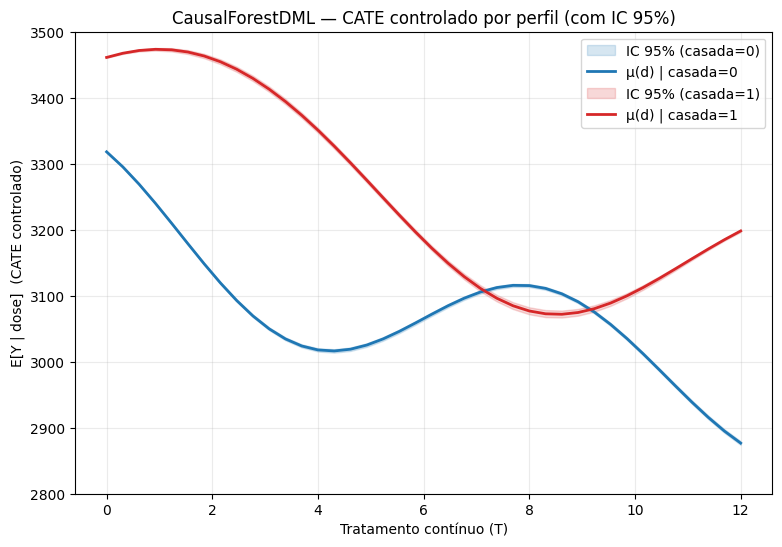

In [44]:
# ----------------------------------------------------------
# 6) Plot final
# ----------------------------------------------------------
plt.figure(figsize=(9,6))
plt.fill_between(t_grid, lo_A, hi_A, color='#1f77b4', alpha=0.18, label='IC 95% (casada=0)')
plt.plot(t_grid, mu_A, color='#1f77b4', lw=2, label='μ(d) | casada=0')

plt.fill_between(t_grid, lo_B, hi_B, color='#d62728', alpha=0.18, label='IC 95% (casada=1)')
plt.plot(t_grid, mu_B, color='#d62728', lw=2, label='μ(d) | casada=1')

plt.axhline(0, color='k', ls='--', lw=0.8)
plt.xlabel("Tratamento contínuo (T)")
plt.ylabel("E[Y | dose]  (CATE controlado)")
plt.title("CausalForestDML — CATE controlado por perfil (com IC 95%)")
plt.ylim(2800, 3500) 
plt.grid(True, alpha=0.25)
plt.legend()
plt.show()

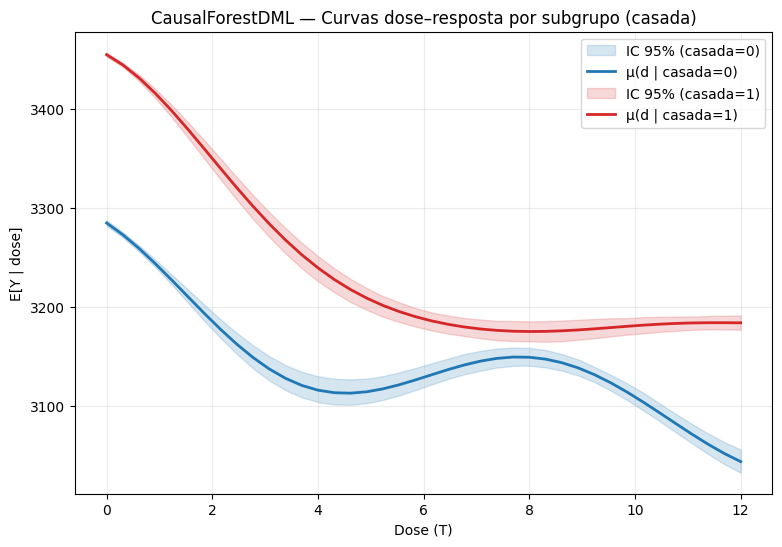

In [33]:
# ==========================================================
# Curvas dose–resposta heterogêneas por subgrupo (casada=0 vs 1)
# Reusa cf, tfeat, outcome_model, Xn, T, t_grid, t0 do bloco anterior
# ==========================================================
B = 300
alpha = 0.05
rng = np.random.default_rng(42)

# Índices de cada grupo conforme df_ usado no fit
g_all = df_['casada'].to_numpy().astype(int)
idx_g0 = np.where(g_all == 0)[0]
idx_g1 = np.where(g_all == 1)[0]

def subgroup_curve(idx_group, label, color, M_target=600):
    # Amostra X do subgrupo (para média rápida)
    M = min(M_target, len(idx_group))
    if M == 0:
        raise ValueError(f"Subgrupo {label} vazio.")
    sub_idx = rng.choice(idx_group, size=M, replace=False)
    Xsub = Xn[sub_idx]

    # Nível no baseline: E[Y|t0, X] com o mesmo outcome_model
    y0_hat = predict_y_at_t(Xsub, t0)  # (M,)

    # Efeitos CF para cada dose do grid
    G = len(t_grid)
    Eff = np.empty((G, M), dtype=np.float32)
    for g, t1 in enumerate(t_grid):
        T0 = np.full((M, 1), t0, dtype=np.float32)
        T1 = np.full((M, 1), t1, dtype=np.float32)
        Eff[g, :] = cf.effect(Xsub, T0=T0, T1=T1)

    # μ(d | grupo) = média_Xsub [ y0_hat + τ(X; t0→d) ]
    mu_hat = (y0_hat[None, :] + Eff).mean(axis=1)

    # Bootstrap nas unidades do grupo
    boot_mu = np.empty((B, G), dtype=np.float32)
    for b in range(B):
        samp = rng.integers(0, M, size=M)  # reamostra colunas
        boot_mu[b, :] = (y0_hat[samp][None, :] + Eff[:, samp]).mean(axis=1)

    lo = np.percentile(boot_mu, 100*(alpha/2), axis=0)
    hi = np.percentile(boot_mu, 100*(1-alpha/2), axis=0)

    # Plot
    plt.fill_between(t_grid, lo, hi, color=color, alpha=0.18, label=f'IC 95% ({label})')
    plt.plot(t_grid, mu_hat, color=color, lw=2, label=f'μ(d | {label})')

# --------- Plot conjunto ---------
plt.figure(figsize=(9,6))
subgroup_curve(idx_g0, label='casada=0', color='#1f77b4')  # azul
subgroup_curve(idx_g1, label='casada=1', color='#d62728')  # vermelho
# baseline visual (opcional): nível médio do grupo casada=0 em t0
# plt.axvline(t0, color='k', ls='--', lw=0.8, label=f't0={t0:.1f}')
plt.xlabel("Dose (T)")
plt.ylabel("E[Y | dose]")
plt.title("CausalForestDML — Curvas dose–resposta por subgrupo (casada)")
plt.grid(True, alpha=0.25)
plt.legend()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- Parâmetros de robustez/velocidade ----------
B_BOOT   = 300        # # de replicações bootstrap (reduza p/ ainda mais rápido)
M_TARGET = 800        # no. máx. de unidades por grupo para a média (cap de memória)
CHUNK    = 400        # processar efeitos em blocos (economiza RAM)
alpha    = 0.05
rng      = np.random.default_rng(123)

# --- índices dos grupos na mesma amostra usada no fit ---
g_all = df_['casada'].to_numpy().astype(int)
idx_g0 = np.where(g_all == 0)[0]
idx_g1 = np.where(g_all == 1)[0]

# --- grid em região de overlap dos grupos (evita extrapolação) ---
def group_grid_overlap(T, idx0, idx1, G=40):
    t0_lo, t0_hi = np.percentile(T[idx0], [2, 98])
    t1_lo, t1_hi = np.percentile(T[idx1], [2, 98])
    lo = max(t0_lo, t1_lo); hi = min(t0_hi, t1_hi)
    if not np.isfinite(lo) or not np.isfinite(hi) or lo >= hi:
        lo, hi = np.percentile(T, [5, 95])
    return np.linspace(float(lo), float(hi), G).astype(np.float32)

t0 = float(np.percentile(T, 5))
t_grid = group_grid_overlap(T, idx_g0, idx_g1, G=40)

# --- função utilitária: baseline por unidade em t_scalar ---
def yhat_at_t(Xblock, t_scalar):
    m = Xblock.shape[0]
    Tt = np.full((m, 1), t_scalar, dtype=np.float32)
    Ph = tfeat.transform(Tt)
    Z  = np.hstack([Xblock, Ph])
    return outcome_model.predict(Z).astype(np.float32)

# --- calcula curva média de um grupo via bootstrap de unidades ---
def group_curve_bootstrap(idx_group, color, label):
    # amostra até M_TARGET unidades do grupo p/ controlar RAM/tempo
    n_full = len(idx_group)
    m = min(M_TARGET, n_full)
    sub_idx = rng.choice(idx_group, size=m, replace=False)
    Xg = Xn[sub_idx]

    # baseline por unidade
    y0_vec = yhat_at_t(Xg, t0)   # (m,)

    # efeitos por unidade e por dose, em blocos CHUNK p/ não estourar memória
    G = len(t_grid)
    Eff = np.empty((G, m), dtype=np.float32)
    for g, t1 in enumerate(t_grid):
        T0m = np.full((m, 1), t0, dtype=np.float32)
        T1m = np.full((m, 1), t1, dtype=np.float32)
        # em blocos:
        out = np.empty(m, dtype=np.float32)
        for s in range(0, m, CHUNK):
            e = min(s+CHUNK, m)
            out[s:e] = cf.effect(Xg[s:e], T0=T0m[s:e], T1=T1m[s:e]).astype(np.float32)
        Eff[g, :] = out

    # média pontual da curva do grupo
    mu_hat = (y0_vec[None, :] + Eff).mean(axis=1)  # (G,)

    # bootstrap nas unidades (barato; não refita nada)
    boot_mu = np.empty((B_BOOT, G), dtype=np.float32)
    for b in range(B_BOOT):
        samp = rng.integers(0, m, size=m)  # reamostra colunas
        boot_mu[b, :] = (y0_vec[samp][None, :] + Eff[:, samp]).mean(axis=1)

    lo = np.percentile(boot_mu, 100*(alpha/2), axis=0)
    hi = np.percentile(boot_mu, 100*(1-alpha/2), axis=0)

    # plot
    plt.fill_between(t_grid, lo, hi, color=color, alpha=0.18, label=f'IC 95% ({label})')
    plt.plot(t_grid, mu_hat, color=color, lw=2, label=f'μ(d | {label})')

# --------- Plot conjunto ---------
plt.figure(figsize=(9,6))
group_curve_bootstrap(idx_g0, color='#1f77b4', label='casada=0')
group_curve_bootstrap(idx_g1, color='#d62728', label='casada=1')
plt.xlabel("Dose (T)")
plt.ylabel("E[Y | dose]")
plt.title("CausalForestDML — Curvas dose–resposta por subgrupo (mem-safe)")
plt.grid(True, alpha=0.25); plt.legend(); plt.show()


### DML with Mediator Continuous Treatment

In [ ]:
%cd "C:/Users/danie/OneDrive/python/double-debiased-machine-learning-mediation-continuous-treatments"
import os
os.getcwd()

C:\Users\danie\OneDrive\python\double-debiased-machine-learning-mediation-continuous-treatments


'C:\\Users\\danie\\OneDrive\\python\\double-debiased-machine-learning-mediation-continuous-treatments'

In [7]:
import numpy as np
import pandas as pd
from data.uniform import UniformEnv

# 1) data_settings iguais aos dos scripts
data_settings = {
    'expname': 'debug',
    'data': 'uniform',
    'n_samples': 2000,
    'mediator_dimension': 1,
    'covariate_dimension': 1,
    'alpha': 0.5,
    'beta': 0.25,
    'stochasticity': 1.0,
    'gamma': 0.3,
    'noise': 'uniform',
}

# 2) instanciar o ambiente
env = UniformEnv(data_settings)

# 3) CHAMADA EXPLÍCITA: params=None e mode='train'
x, t, m, y, params = env.generate_causal_data(
    data_settings,
    params=None,
    random_state=42,
    mode='train',        # <- força o ramo que cria X
)

# 4) converter para DataFrame
df = pd.DataFrame({
    'X1': x[:, 0],
    'T': t.squeeze(),
    'M': m[:, 0] if m.ndim > 1 else m,
    'Y': y.squeeze(),
})


In [10]:
df.to_markdown

<bound method DataFrame.to_markdown of             X1         T         M         Y
0    -0.376380  0.480114  0.319104 -0.722055
1     1.352143 -0.904812  1.355929 -1.269726
2     0.695982  1.698373  1.758950  5.589413
3     0.295975  0.541258 -1.133230 -1.357658
4    -1.031944 -1.680768 -2.216816 -1.715117
...        ...       ...       ...       ...
1995  0.470865 -0.766102  0.649171 -0.486466
1996  1.369844 -0.750970  0.198544 -0.597599
1997 -1.293126 -0.566623  0.502671 -1.016727
1998 -1.328836  1.235099 -0.086958  0.482880
1999 -0.653439 -1.778110 -2.131938 -2.233618

[2000 rows x 4 columns]>

In [11]:
import numpy as np
import pandas as pd

# ===== 1) escolher doses (d, d') a partir dos seus dados =====
q = df['T'].quantile
d, d_prime = float(q(0.25)), float(q(0.75))   # pode trocar por quantis/valores que fizerem sentido

# ===== 2) preparar arrays com formatos esperados =====
Y = df['Y'].to_numpy().astype(float).ravel()
T = df['T'].to_numpy().astype(float).ravel()
M = df[['M']].to_numpy().astype(float)        # 2-D
X = df[['X1']].to_numpy().astype(float)       # 2-D; acrescente mais colunas se tiver

# ===== 3) settings no formato que o repo exige =====
param_settings = {
    'regularization': True,     # base.Estimator acessa esta chave
    'sample_splits': 1,         # cross-fitting (1 = desliga; mude p/ 2 se quiser)
    'reg_lambda': 1e-3,
    'reg_lambda_tilde': 1e-3,
    'kernel': 'gauss',
    'density': 'gaussian',      # opções vistas no repo: 'gaussian', 'conditional_kernel', 'ls_conditional'
    'bandwidth': 0.3,           # precisa existir; ajuste se necessário
    'bandwidth_mode': 'heuristic',  # ou 'amse' (alguns scripts usam), 'auto', 'scott' etc.
    'epsilon': 0.3,             # usado em rotinas KME/AMSE
    'normalized': True,
}

# ===== 4) importar estimadores exatamente pelos nomes/classes do repositório =====
from estimators.linear import Linear
from estimators.ipw import ImportanceWeighting
from estimators.kme_g_computation import KMEGComputation
from estimators.kme_dml import KMEDoubleMachineLearning
from estimators.sani_dml import SaniDoubleMachineLearning
from estimators.sani_kme_dml import SaniKMEDoubleMachineLearning

estimators = [
    ("OLS_linear", Linear),
    ("IPW", ImportanceWeighting),
    ("KME_Gcomp", KMEGComputation),
    ("DML_KME", KMEDoubleMachineLearning),
    ("Sani_DML", SaniDoubleMachineLearning),
    ("Sani_KME_DML", SaniKMEDoubleMachineLearning),
]

def run_one(cls, settings, y, t, m, x, d, d_prime):
    est = cls(settings, False)           # construtor posicional: (settings, verbose)
    est.fit(t, m, x, y)
    out = est.estimate(d, d_prime, t, m, x, y)   # API comum no seu repo
    # garantir chaves sempre presentes
    out = {**{'total_effect': np.nan, 'direct_effect': np.nan, 'indirect_effect': np.nan,
              'mediated_response': np.nan, 'variance': np.nan, 'margin_error': np.nan}, **out}
    return out

rows = []
for name, Cls in estimators:
    try:
        res = run_one(Cls, param_settings, Y, T, M, X, d, d_prime)
        rows.append({
            'model': name,
            'd': d, 'd_prime': d_prime,
            'total': res['total_effect'],
            'direct': res['direct_effect'],
            'indirect': res['indirect_effect'],
            'mediated_response': res['mediated_response'],
            'variance': res['variance'],
            'margin_error': res['margin_error'],
        })
    except Exception as e:
        rows.append({'model': name, 'error': str(e)})

results = pd.DataFrame(rows).set_index('model')
results


c:\Users\danie\OneDrive\python\.venv-dmlmed\Lib\site-packages\sklearn\linear_model\_logistic.py:1946: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,d,d_prime,total,direct,indirect,mediated_response,variance,margin_error
model,,,,,,,,
OLS_linear,-1.054579,0.944545,1.986474,1.811160,0.175314,-0.863919,0.000000,0.000000
IPW,-1.054579,0.944545,1.046889,0.468794,0.578096,-0.564998,0.000000,0.000000
KME_Gcomp,-1.054579,0.944545,1.341368,-0.089829,1.431198,0.319836,0.000000,0.000000
DML_KME,-1.054579,0.944545,1.282995,0.906110,0.376886,-0.551220,3.259047,0.150749
Sani_DML,-1.054579,0.944545,1.325523,-2.894817,4.220340,4.661449,34234.873919,15.450562
Sani_KME_DML,-1.054579,0.944545,1.282995,0.902797,0.380198,-0.580771,3.099448,0.147012


In [12]:
results.to_markdown

<bound method DataFrame.to_markdown of                      d   d_prime     total    direct  indirect  \
model                                                            
OLS_linear   -1.054579  0.944545  1.986474  1.811160  0.175314   
IPW          -1.054579  0.944545  1.046889  0.468794  0.578096   
KME_Gcomp    -1.054579  0.944545  1.341368 -0.089829  1.431198   
DML_KME      -1.054579  0.944545  1.282995  0.906110  0.376886   
Sani_DML     -1.054579  0.944545  1.325523 -2.894817  4.220340   
Sani_KME_DML -1.054579  0.944545  1.282995  0.902797  0.380198   

              mediated_response      variance  margin_error  
model                                                        
OLS_linear            -0.863919      0.000000      0.000000  
IPW                   -0.564998      0.000000      0.000000  
KME_Gcomp              0.319836      0.000000      0.000000  
DML_KME               -0.551220      3.259047      0.150749  
Sani_DML               4.661449  34234.873919     15.450562 

In [26]:
# --- ajustar settings e rodar o SaniDML oficial ---
settings = {
    # exigidos pela classe base
    "regularization": 1e-6,
    "bandwidth": 0.3,
    "bandwidth_mode": "cv",
    "normalized": True,
    "sample_splits": 1,

    # este é o que faltava p/ f(T|X):
    "density": "ls_conditional",   # usa Least-Squares Conditional Density Estimation

    # caminho simples para M|T,X: bucketiza M + regressão logística
    "epsilon": "buckets",          # qualquer valor != 'kme' evita dependências extras
}

est = SaniDML(settings=settings, verbose=1)

Y = df["Y"].values
T = df["D"].values
M = df[["M1"]].values
X = df[["X1"]].values

est.fit(t=T, m=M, x=X, y=Y)

d0, d1 = -1.0, 1.0
res_official = est.estimate(d=d0, d_prime=d1, t=T, m=M, x=X, y=Y)

print("=== Estimador oficial (SaniDML) ===")
for k, v in res_official.items():
    print(f"{k:>18s}: {v:.6f}")


c:\Users\danie\OneDrive\python\.venv-dmlmed\Lib\site-packages\sklearn\linear_model\_logistic.py:1946: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Nuisance models fitted
=== Estimador oficial (SaniDML) ===
      total_effect: -112.331583
     direct_effect: -298.206993
   indirect_effect: 185.875411
 mediated_response: -200.037398
          variance: 1577393.784020
      margin_error: 82.443546


In [29]:
import numpy as np

# Extraia resultados oficiais
te = float(res_official["total_effect"])
de = float(res_official["direct_effect"])
ie = float(res_official["indirect_effect"])
var = float(res_official["variance"])
se = np.sqrt(var)
me = 1.96 * se

# IC 95% aproximado
ic_te = (te - me, te + me)
ic_de = (de - me, de + me)
ic_ie = (ie - me, ie + me)

print("=== Intervalos de confiança (95%) ===")
print(f"Total effect   : {ic_te[0]:.2f}  —  {ic_te[1]:.2f}")
print(f"Direct effect  : {ic_de[0]:.2f}  —  {ic_de[1]:.2f}")
print(f"Indirect effect: {ic_ie[0]:.2f}  —  {ic_ie[1]:.2f}")


=== Intervalos de confiança (95%) ===
Total effect   : -2573.98  —  2349.32
Direct effect  : -2759.86  —  2163.44
Indirect effect: -2275.77  —  2647.52


In [30]:
print("Bandwidth usado:", est._bandwidth)


Bandwidth usado: 0.29716778793522935


In [31]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
Y_std = sc.fit_transform(Y.reshape(-1,1)).ravel()
T_std = sc.fit_transform(T.reshape(-1,1)).ravel()
M_std = sc.fit_transform(M)
X_std = sc.fit_transform(X)

res_std = est.estimate(d=-1.0, d_prime=1.0, t=T_std, m=M_std, x=X_std, y=Y_std)


In [35]:
print("=== Estimador oficial (SaniDML) ===")
for k, v in res_std.items():
    print(f"{k:>18s}: {v:.6f}")

=== Estimador oficial (SaniDML) ===
      total_effect: 181.055586
     direct_effect: -280.931504
   indirect_effect: 461.987090
 mediated_response: -162.910343
          variance: 1495743.851585
      margin_error: 80.281451


In [36]:
import numpy as np

te = 181.055586
de = -280.931504
ie = 461.987090
var = 1495743.851585
se = np.sqrt(var)
me = 1.96 * se

print("=== Intervalos de confiança (95%) ===")
print(f"Total effect   : {te - me:.2f}  —  {te + me:.2f}")
print(f"Direct effect  : {de - me:.2f}  —  {de + me:.2f}")
print(f"Indirect effect: {ie - me:.2f}  —  {ie + me:.2f}")



=== Intervalos de confiança (95%) ===
Total effect   : -2216.04  —  2578.15
Direct effect  : -2678.02  —  2116.16
Indirect effect: -1935.10  —  2859.08


In [28]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from pprint import pprint

# ==== Recria ou reutiliza os modelos mod_M e mod_Y ====
try:
    mod_M, mod_Y
except NameError:
    mod_M = RandomForestRegressor(n_estimators=700, random_state=5).fit(
        np.column_stack([T, X]), M
    )
    mod_Y = RandomForestRegressor(n_estimators=700, random_state=6).fit(
        np.column_stack([M, T, X]), Y
    )

# ==== Gera previsões contrafactuais ====
Xbar = X.mean(axis=0, keepdims=True)
M_d0 = mod_M.predict(np.column_stack([np.full((1,1), d0), Xbar]))
M_d1 = mod_M.predict(np.column_stack([np.full((1,1), d1), Xbar]))

EY_d0_Md0 = mod_Y.predict(np.column_stack([M_d0, [[d0]], Xbar]))[0]
EY_d1_Md1 = mod_Y.predict(np.column_stack([M_d1, [[d1]], Xbar]))[0]
EY_d1_Md0 = mod_Y.predict(np.column_stack([M_d0, [[d1]], Xbar]))[0]

plug_total    = float(EY_d1_Md1 - EY_d0_Md0)
plug_direct   = float(EY_d1_Md0 - EY_d0_Md0)
plug_indirect = float(plug_total - plug_direct)

# ==== Impressão lado a lado ====
print("=== Comparação: estimador oficial vs pipeline didático ===\n")

print("Oficial (SaniDML):")
pprint(res_official)

print("\nDidático (plug-in em d0, d1):")
print(f"{'total_effect':>18s}: {plug_total:.6f}")
print(f"{'direct_effect':>18s}: {plug_direct:.6f}")
print(f"{'indirect_effect':>18s}: {plug_indirect:.6f}")


=== Comparação: estimador oficial vs pipeline didático ===

Oficial (SaniDML):
{'direct_effect': np.float64(-298.20699318823546),
 'indirect_effect': np.float64(185.87541053564144),
 'margin_error': np.float64(82.44354550856377),
 'mediated_response': np.float64(-200.03739837757638),
 'total_effect': np.float64(-112.33158265259404),
 'variance': np.float64(1577393.7840204746)}

Didático (plug-in em d0, d1):
      total_effect: 5.038591
     direct_effect: 1.196650
   indirect_effect: 3.841941


In [27]:
# comparação lado a lado
from pprint import pprint

print("\nOficial (SaniDML):")
pprint(res_official)

print("\nDidático (plug-in em d0,d1):")
print(f"{'total_effect':>18s}: {plug_total:.6f}")
print(f"{'direct_effect':>18s}: {plug_direct:.6f}")
print(f"{'indirect_effect':>18s}: {plug_indirect:.6f}")



Oficial (SaniDML):
{'direct_effect': np.float64(-298.20699318823546),
 'indirect_effect': np.float64(185.87541053564144),
 'margin_error': np.float64(82.44354550856377),
 'mediated_response': np.float64(-200.03739837757638),
 'total_effect': np.float64(-112.33158265259404),
 'variance': np.float64(1577393.7840204746)}

Didático (plug-in em d0,d1):


NameError: name 'plug_total' is not defined

In [24]:
# ===== tente este settings =====
settings = {
    # Estimator/base
    "regularization": 1e-6,     # lambda (qualquer valor pequeno >0)
    "bandwidth": 0.3,           # largura de banda inicial p/ kernel em T
    "bandwidth_mode": "cv",     # ou "scott" / "silverman" se preferir
    "normalized": True,         # normaliza os escores
    "sample_splits": 1,         # 1 = sem CF interno (mais simples)

    # SaniDML
    "epsilon": "buckets",       # != 'kme' => discretiza M com KMeans + LR

    # (opcionais / dependem da sua versão do repo)
    # "tx_density": "ls",       # se o fit_tx_density exigir explicitamente
    # "density": "ls_conditional",  # não é usado no caminho 'buckets'
}


In [25]:
est = SaniDML(settings=settings, verbose=1)

Y = df["Y"].values
T = df["D"].values
M = df[["M1"]].values
X = df[["X1"]].values

est.fit(t=T, m=M, x=X, y=Y)

d0, d1 = -1.0, 1.0
res_official = est.estimate(d=d0, d_prime=d1, t=T, m=M, x=X, y=Y)

print("=== Estimador oficial (SaniDML) ===")
for k, v in res_official.items():
    print(f"{k:>18s}: {v:.6f}")


c:\Users\danie\OneDrive\python\.venv-dmlmed\Lib\site-packages\sklearn\linear_model\_logistic.py:1946: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


KeyError: 'density'

In [23]:
# === Célula 1: carregar classe oficial e instanciar ===
import os, sys, importlib.util

REPO = r"C:\Users\danie\OneDrive\python\double-debiased-machine-learning-mediation-continuous-treatments"
if REPO not in sys.path:
    sys.path.append(REPO)

# Carrega estimators/sani_dml.py
path = os.path.join(REPO, "estimators", "sani_dml.py")
spec = importlib.util.spec_from_file_location("sani_dml_mod", path)
sani_dml_mod = importlib.util.module_from_spec(spec)
spec.loader.exec_module(sani_dml_mod)

SaniDML = sani_dml_mod.SaniDoubleMachineLearning
print("Classe carregada:", SaniDML)

# Settings mínimos, de acordo com o __init__ que você colou:
settings = {
    "normalized": True,        # normaliza os escores nos termos do kernel (opcional)
    "sample_splits": 1,        # 1 = sem cross-fitting interno (usa o full sample)
    "bandwidth_mode": "cv",    # o base costuma aceitar 'cv'/'silverman'/'scott' (depende do repo)
    "epsilon": "buckets",      # qualquer string != 'kme' ativa o caminho de discretização (KMeans+LR)
    # se seu repo exigir, podemos adicionar: "density": "ls_conditional", etc.
}

est = SaniDML(settings=settings, verbose=1)
est


Classe carregada: <class 'sani_dml_mod.SaniDoubleMachineLearning'>


KeyError: 'regularization'

In [ ]:
# === Célula 2: fit + estimate no estimador oficial ===
import numpy as np

Y = df["Y"].values
T = df["D"].values
M = df[["M1"]].values   # (n, 1) — se tivesse vários: df[[...]].values
X = df[["X1"]].values   # (n, 1)

# Ajuste os dois pontos de comparação do tratamento:
d0 = -1.0
d1 =  1.0

# Treina os "nuisances" internos do estimador original
est.fit(t=T, m=M, x=X, y=Y)

# Estima efeitos totais/diretos/indiretos (d -> d′)
res_official = est.estimate(d=d0, d_prime=d1, t=T, m=M, x=X, y=Y)

print("=== Estimador oficial (SaniDoubleMachineLearning) ===")
for k, v in res_official.items():
    print(f"{k:>18s}: {v:.6f}")


In [15]:
import os, sys, importlib.util, numpy as np, pandas as pd

REPO = r"C:\Users\danie\OneDrive\python\double-debiased-machine-learning-mediation-continuous-treatments"
if REPO not in sys.path:
    sys.path.append(REPO)

# Carrega data/uniform.py
path = os.path.join(REPO, "data", "uniform.py")
spec = importlib.util.spec_from_file_location("uniform_mod", path)
uniform_mod = importlib.util.module_from_spec(spec)
spec.loader.exec_module(uniform_mod)

UniformEnv = getattr(uniform_mod, "UniformEnv")

# SETTINGS exigidos pelo __init__
settings = {
    "alpha": 0.5,            # efeito interação T*M em Y
    "beta": 0.25,            # termo T^3 em Y
    "gamma": 0.8,            # 'coeff' (força de T->M e T/X->Y)
    "stochasticity": 1.0,    # 1.0 ou True
    "noise": "gaussian",     # "gaussian" ou "uniform"
    "mediator_dimension": 1  # <-- 1 mediator para evitar o bug do 'M =+'
}

env = UniformEnv(settings)

data_settings = {"n_samples": 3000}

X, T, M, Y, params = env.generate_causal_data(
    data_settings=data_settings,
    random_state=123,
    mode="id"    # mantenha 'id' (default do método)
)

# Monta DataFrame Y, D, M1.., X1..
def to_df(X, T, M, Y):
    Y = np.asarray(Y).ravel()
    D = np.asarray(T).ravel()
    M = np.atleast_2d(M);  M = M if M.shape[0] == len(Y) else M.T
    X = np.atleast_2d(X);  X = X if X.shape[0] == len(Y) else X.T
    df = pd.DataFrame({"Y": Y, "D": D})
    for j in range(M.shape[1]): df[f"M{j+1}"] = M[:, j]
    for k in range(X.shape[1]): df[f"X{k+1}"] = X[:, k]
    return df

df_repo = to_df(X, T, M, Y)
df_repo.head(), df_repo.shape


(          Y         D        M1        X1
 0 -1.505769  0.263034 -0.431171 -1.085631
 1  0.549433  0.476366 -1.219584  0.997345
 2  2.257328  0.618530  0.273349  0.282978
 3 -2.887061 -1.747034 -2.405278 -1.506295
 4 -1.802313 -1.976266 -1.416528 -0.578600,
 (3000, 4))

In [14]:
import os, sys, inspect, importlib.util

REPO = r"C:\Users\danie\OneDrive\python\double-debiased-machine-learning-mediation-continuous-treatments"
if REPO not in sys.path:
    sys.path.append(REPO)

path = os.path.join(REPO, "data", "uniform.py")
spec = importlib.util.spec_from_file_location("uniform_mod", path)
uniform_mod = importlib.util.module_from_spec(spec)
spec.loader.exec_module(uniform_mod)

print(inspect.getsource(uniform_mod.UniformEnv.generate_causal_data))


    def generate_causal_data(self, data_settings, 
                            params=params,
                            random_state=42,
                            mode='id'):
        
        n_samples = data_settings['n_samples']
        
        rng = np.random.RandomState(random_state)
        
        if self.noise == 'uniform':
            X = rng.uniform(-1.5, 1.5, size=(n_samples,1))
            U = self.stochasticity*rng.uniform(-2, 2, size=(n_samples,1))
            V = self.stochasticity*rng.uniform(-2, 2, size=(n_samples,1))
            W = self.stochasticity*rng.uniform(-2, 2, size=(n_samples,1))
            
        elif self.noise == 'gaussian':

            X = rng.normal(size=(n_samples,1))
            U = self.stochasticity*rng.normal(size=(n_samples,1))
            V = self.stochasticity*rng.normal(size=(n_samples,1))
            W = self.stochasticity*rng.normal(size=(n_samples,1))
        

        T = self.coeff*X+W
        M = self.coeff*T+self.coeff*X+V
     

In [13]:
import os, sys, importlib.util, numpy as np, pandas as pd

REPO = r"C:\Users\danie\OneDrive\python\double-debiased-machine-learning-mediation-continuous-treatments"
if REPO not in sys.path:
    sys.path.append(REPO)

# Carrega data/uniform.py
path = os.path.join(REPO, "data", "uniform.py")
spec = importlib.util.spec_from_file_location("uniform_mod", path)
uniform_mod = importlib.util.module_from_spec(spec)
spec.loader.exec_module(uniform_mod)

UniformEnv = getattr(uniform_mod, "UniformEnv")

# -------- SETTINGS OBRIGATÓRIOS (pelas chaves vistas no __init__) --------
settings = {
    "alpha": 0.5,               # peso do(s) mediador(es) em Y (interpretação didática)
    "beta": 0.25,               # efeito direto de D em Y (interpretação didática)
    "gamma": 0.8,               # força de D -> M (caminho de mediação)
    "stochasticity": True,      # se a geração tem ruído estocástico
    "noise": 1.0,               # nível de ruído
    "mediator_dimension": 3,    # nº de mediadores M (M1..M_p)  <-- ajuste aqui se quiser
}

env = UniformEnv(settings)

# -------- data_settings para a amostra --------
# (pela prática do repo, 'n_samples' é usado; nº de X costuma ser inferido ou fixo internamente)
data_settings = {
    "n_samples": 3000,
    # se o método exigir algo como 'd_x' ou outros, adicione aqui:
    # "d_x": 5,
}

# params tem defaults (alpha/beta), mas já passamos no settings; pode deixar default
out = env.generate_causal_data(
    data_settings=data_settings,
    random_state=123,
    mode="id"  # deixe como 'id' a menos que você queira outro cenário do próprio script
)

# Normaliza saída para DataFrame Y, D, M1.., X1..
def to_df_from_env_output(out, prefix_m="M", prefix_x="X"):
    # no repo: tipicamente (x, t, m, y, params)
    if isinstance(out, (list, tuple)) and len(out) >= 4:
        x, t, m, y = out[0], out[1], out[2], out[3]
    elif isinstance(out, dict):
        y = out.get("Y") or out.get("y")
        t = out.get("D") or out.get("T") or out.get("t")
        m = out.get("M") or out.get("m")
        x = out.get("X") or out.get("x")
    else:
        raise ValueError("Formato inesperado do retorno.")
    y = np.asarray(y).ravel()
    t = np.asarray(t).ravel()
    m = np.atleast_2d(m); m = m if m.shape[0] == len(y) else m.T
    x = np.atleast_2d(x); x = x if x.shape[0] == len(y) else x.T
    df = pd.DataFrame({"Y": y, "D": t})
    for j in range(m.shape[1]):
        df[f"{prefix_m}{j+1}"] = m[:, j]
    for k in range(x.shape[1]):
        df[f"{prefix_x}{k+1}"] = x[:, k]
    return df

df_repo = to_df_from_env_output(out)
print(df_repo.head())
print("shape:", df_repo.shape)
print("cols:", df_repo.columns.tolist())


UnboundLocalError: cannot access local variable 'X' where it is not associated with a value

In [10]:
import os, sys, inspect, importlib.util

REPO = r"C:\Users\danie\OneDrive\python\double-debiased-machine-learning-mediation-continuous-treatments"
if REPO not in sys.path:
    sys.path.append(REPO)

# Carregar o módulo data/uniform.py
path = os.path.join(REPO, "data", "uniform.py")
spec = importlib.util.spec_from_file_location("uniform_mod", path)
uniform_mod = importlib.util.module_from_spec(spec)
spec.loader.exec_module(uniform_mod)

UniformEnv = getattr(uniform_mod, "UniformEnv")
print("Assinatura de UniformEnv.generate_causal_data:")
print(inspect.signature(UniformEnv.generate_causal_data))


Assinatura de UniformEnv.generate_causal_data:
(self, data_settings, params={'alpha': 0.5, 'beta': 0.25}, random_state=42, mode='id')


In [12]:
import os, sys, inspect, importlib.util

REPO = r"C:\Users\danie\OneDrive\python\double-debiased-machine-learning-mediation-continuous-treatments"
if REPO not in sys.path:
    sys.path.append(REPO)

# Carrega data/uniform.py
path = os.path.join(REPO, "data", "uniform.py")
spec = importlib.util.spec_from_file_location("uniform_mod", path)
uniform_mod = importlib.util.module_from_spec(spec)
spec.loader.exec_module(uniform_mod)

print("===== UniformEnv.__init__ =====")
print(inspect.getsource(uniform_mod.UniformEnv.__init__))

# Também veja o __init__ da base
base_path = os.path.join(REPO, "data", "base.py")
spec2 = importlib.util.spec_from_file_location("base_mod", base_path)
base_mod = importlib.util.module_from_spec(spec2)
spec2.loader.exec_module(base_mod)

print("\n===== CausalEnvironment.__init__ =====")
print(inspect.getsource(base_mod.CausalEnvironment.__init__))


===== UniformEnv.__init__ =====
    def __init__(self, *args):
        """IPW estimator

        Attributes:
            _clip (float):  clipping the propensities
            _trim (float): remove propensities which are below the trim threshold

        """
        super(UniformEnv, self).__init__(*args)
        grid = np.arange(-1.5, 1.5, 0.1)
        self.grid = np.delete(grid, 15)
        self.name = 'Uniform'
        if self._settings:
            self.alpha = self._settings['alpha']
            self.beta = self._settings['beta']
        else:
            self.alpha = params['alpha']
            self.beta = params['beta']

        self.coeff = self._settings['gamma']
        self.stochasticity = self._settings['stochasticity']

        self.alpha = self._settings['alpha']
        self.beta = self._settings['beta']
        self.coeff = self._settings['gamma']
        self.stochasticity = self._settings['stochasticity']
        self.noise = self._settings['noise']
        self.mediat

In [11]:
# Instancia o ambiente e gera dados
env = UniformEnv()

# data_settings: ajuste d_m (nº de mediadores) e d_x (nº de X) se a assinatura exigir
data_settings = {
    "n_samples": 3000,
    "d_m": 3,   # nº mediadores
    "d_x": 5    # nº covariáveis
}

out = env.generate_causal_data(data_settings=data_settings, random_state=123)
type(out), len(out)


TypeError: 'NoneType' object is not subscriptable

In [9]:
import os, sys, inspect, importlib.util

REPO = r"C:\Users\danie\OneDrive\python\double-debiased-machine-learning-mediation-continuous-treatments"
if REPO not in sys.path:
    sys.path.append(REPO)

# Carrega o módulo uniform.py diretamente
path = os.path.join(REPO, "data", "uniform.py")
spec = importlib.util.spec_from_file_location("uniform_mod", path)
uniform_mod = importlib.util.module_from_spec(spec)
spec.loader.exec_module(uniform_mod)

print("Classes em data.uniform:")
classes = []
for name, obj in inspect.getmembers(uniform_mod, inspect.isclass):
    print("-", name)
    classes.append((name, obj))

print("\nMétodos de cada classe:")
for name, cls in classes:
    methods = [m for m, f in inspect.getmembers(cls, inspect.isfunction)]
    print(f"* {name}:", methods)


Classes em data.uniform:
- CausalEnvironment
- StandardScaler
- UniformEnv

Métodos de cada classe:
* CausalEnvironment: ['__init__', 'causal_experiment', 'generate_causal_data', 'get_causal_effects']
* StandardScaler: ['__getstate__', '__init__', '__repr__', '__setstate__', '__sklearn_clone__', '__sklearn_tags__', '_get_doc_link', '_get_metadata_request', '_get_params_html', '_html_repr', '_repr_html_inner', '_repr_mimebundle_', '_reset', '_validate_params', 'fit', 'fit_transform', 'get_feature_names_out', 'get_metadata_routing', 'get_params', 'inverse_transform', 'partial_fit', 'set_fit_request', 'set_inverse_transform_request', 'set_output', 'set_params', 'set_partial_fit_request', 'set_transform_request', 'transform']
* UniformEnv: ['__init__', 'causal_experiment', 'generate_causal_data', 'get_causal_effects', 'get_mediated_response']


In [7]:
# Ver primeiras 60 linhas para entender a estrutura
import inspect, textwrap
import importlib.util
import os

path = r"C:\Users\danie\OneDrive\python\double-debiased-machine-learning-mediation-continuous-treatments\data\uniform.py"
spec = importlib.util.spec_from_file_location("uniform", path)
uniform = importlib.util.module_from_spec(spec)
spec.loader.exec_module(uniform)

# Mostrar nomes e funções do módulo
print("Funções disponíveis em data.uniform:")
for name, obj in inspect.getmembers(uniform, inspect.isfunction):
    print("-", name)


Funções disponíveis em data.uniform:
- display_experiment_results


In [6]:
import os, sys, inspect, numpy as np, pandas as pd

# Caminho do repositório clonado
REPO = r"C:\Users\danie\OneDrive\python\double-debiased-machine-learning-mediation-continuous-treatments"

if REPO not in sys.path:
    sys.path.append(REPO)

from data.uniform import generate_causal_data  # base sintética principal


ImportError: cannot import name 'generate_causal_data' from 'data.uniform' (C:\Users\danie\OneDrive\python\double-debiased-machine-learning-mediation-continuous-treatments\data\uniform.py)

In [4]:
# === Célula 1: apontar o repo e procurar a função de geração ===
import os, sys, re, importlib.util, pathlib
from pprint import pprint

REPO = r"C:\Users\danie\OneDrive\python\double-debiased-machine-learning-mediation-continuous-treatments"
assert os.path.isdir(REPO), "Verifique o caminho do repositório clonado."
if REPO not in sys.path:
    sys.path.append(REPO)

# Heurística: procurar funções com nomes típicos de geração
PATTERNS = [
    r"def\s+(generate_[a-zA-Z0-9_]+)\s*\(",
    r"def\s+(simulate_[a-zA-Z0-9_]+)\s*\(",
    r"def\s+(sample_[a-zA-Z0-9_]+)\s*\(",
    r"def\s+(make_[a-zA-Z0-9_]+_dataset)\s*\(",
]

candidates = []
for root, _, files in os.walk(REPO):
    for f in files:
        if f.endswith(".py"):
            p = os.path.join(root, f)
            try:
                txt = open(p, "r", encoding="utf-8", errors="ignore").read()
            except:
                continue
            for pat in PATTERNS:
                for m in re.finditer(pat, txt):
                    fn = m.group(1)
                    # filtro leve para evitar funções irrelevantes
                    if any(key in fn for key in ["uniform","baseline","data","dataset","simul","hsu","sani"]):
                        rel = os.path.relpath(p, REPO).replace("\\","/")
                        candidates.append((rel, fn))
candidates = sorted(set(candidates))
print("Possíveis funções geradoras encontradas:")
pprint(candidates[:20])


Possíveis funções geradoras encontradas:
[('data/base.py', 'generate_causal_data'),
 ('data/binomial.py', 'generate_causal_data'),
 ('data/ukbb.py', 'generate_causal_data'),
 ('data/uniform.py', 'generate_causal_data')]


Head do df:
           Y         D        M1        M2        M3        X1        X2  \
0   7.525443  1.440289  1.331335  2.328420  0.353537 -0.989121 -0.367787   
1   2.366796  1.218585  1.187315 -0.594043  1.105787  0.577104 -0.636464   
2  10.177137  2.406180  1.132982  3.609277  3.113474  0.097167 -1.525930   
3  -0.792737 -0.184298 -0.341042 -0.732358  0.642052  0.136321  1.532033   
4   0.596942 -1.217263  0.185426 -0.004424 -0.031959 -2.207471  0.827921   

         X3        X4        X5  
0  1.287925  0.193974  0.920231  
1  0.541952 -0.316595 -0.322389  
2  1.192166 -0.671090  1.000269  
3 -0.659969 -0.311795  0.337769  
4  1.541630  1.126807  0.754770  

Resumo:
     count      mean       std        min       25%       50%       75%  \
Y   3000.0  0.121256  5.787897 -21.571337 -3.800906  0.116174  3.924578   
D   3000.0  0.023240  1.122690  -3.811107 -0.728904 -0.000247  0.781525   
M1  3000.0 -0.004671  1.546881  -4.989024 -1.076437  0.037324  1.039740   
M2  3000.0  0.0331

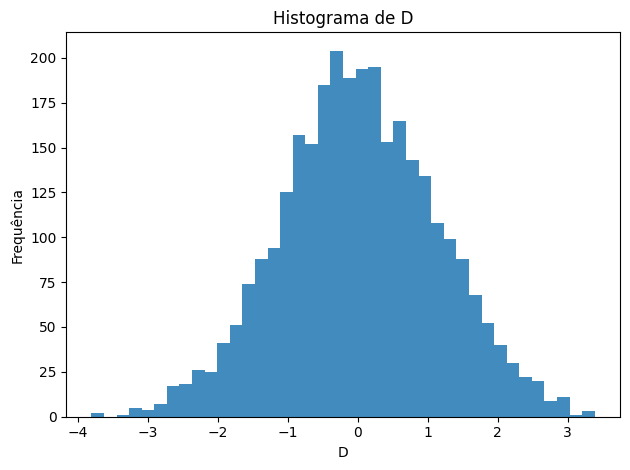

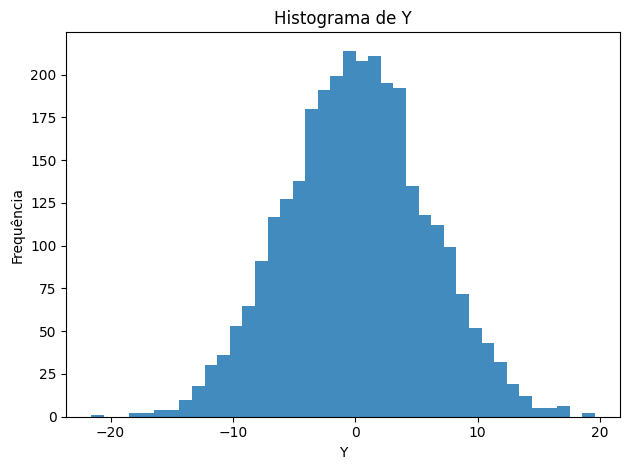

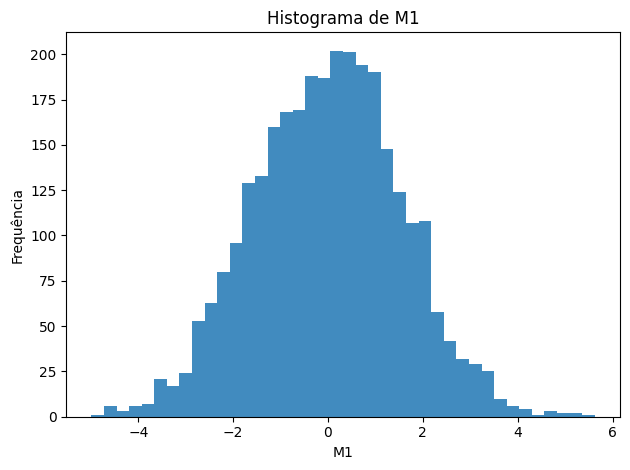

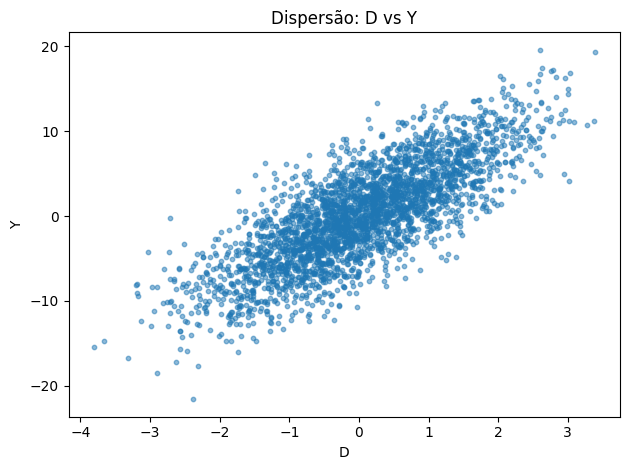

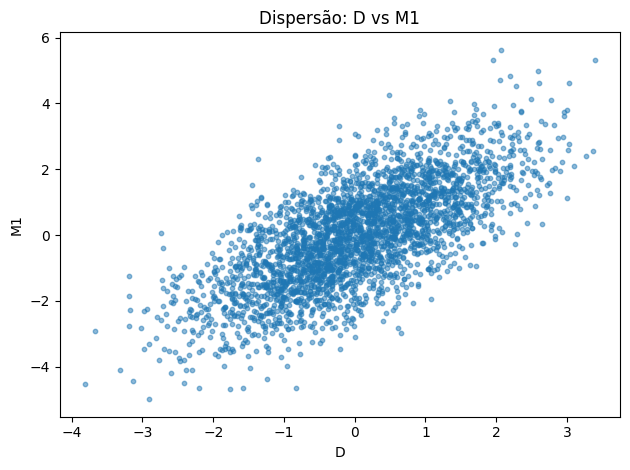

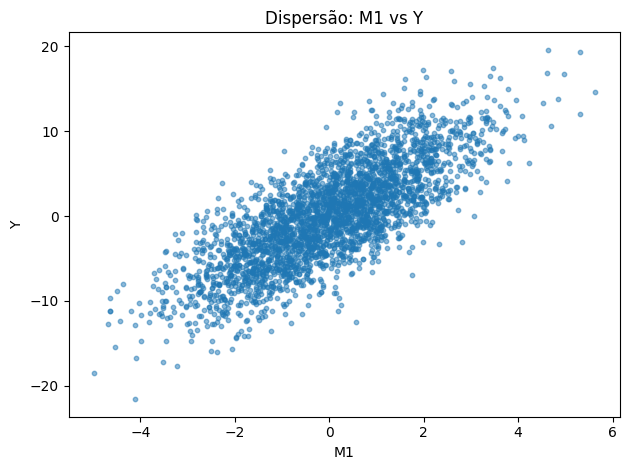

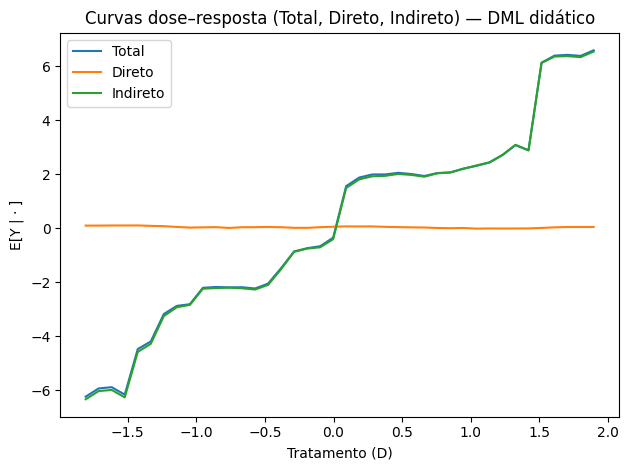

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Dict, List, Tuple, Optional
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# =========================================================
# 0) PARÂMETROS PRINCIPAIS
# =========================================================
N = 3000           # tamanho da amostra
P_M = 3            # nº de mediadores (ex.: 1, 3, 5)
P_X = 5            # nº de covariáveis X
RANDOM_SEED = 123
T_GRID_SIZE = 40   # nº de pontos no grid de dose-resposta
TEST_PLOTS = True  # gerar gráficos simples

rng = np.random.default_rng(RANDOM_SEED)

# =========================================================
# 1) GERAÇÃO DO DATAFRAME (Y, D, M..., X...)
#    - D contínuo
#    - M_j com componente de D (caminho indireto)
#    - Y com efeito direto de D + efeito via M
# =========================================================
def simulate_df(n: int, p_m: int, p_x: int, seed: int = 123) -> pd.DataFrame:
    rng = np.random.default_rng(seed)

    # Covariáveis
    X = rng.normal(0, 1, size=(n, p_x))
    # Tratamento contínuo D com dependência em X (para realismo)
    beta_tx = rng.normal(0.4, 0.2, size=p_x)
    D = 0.6 * (X @ beta_tx) + rng.normal(0, 1, size=n)

    # Mediadores M_j com dependência em D e X
    M = []
    for j in range(p_m):
        gamma_jx = rng.normal(0.5, 0.2, size=p_x)
        Mj = 0.8 * D + 0.6 * (X @ gamma_jx) + rng.normal(0, 1, size=n)
        M.append(Mj)
    M = np.column_stack(M)

    # Resultado Y: efeito direto de D + contribuição dos mediadores + X
    theta_true = 0.3               # efeito direto "verdadeiro"
    alpha_true = rng.normal(0.9, 0.2, size=p_m)  # pesos dos mediadores
    beta_yx = rng.normal(0.5, 0.2, size=p_x)

    Y = theta_true * D + M @ alpha_true + X @ beta_yx + rng.normal(0, 1, size=n)

    # Monta DataFrame
    cols = {}
    df = pd.DataFrame()
    df["Y"] = Y
    df["D"] = D
    for j in range(p_m):
        name_m = f"M{j+1}"
        df[name_m] = M[:, j]
    for k in range(p_x):
        name_x = f"X{k+1}"
        df[name_x] = X[:, k]

    return df

df = simulate_df(N, P_M, P_X, seed=RANDOM_SEED)

# Mapeamento padrão de colunas (você pode alterar depois para outros datasets)
cols: Dict[str, List[str] | str] = {
    "Y": "Y",
    "D": "D",
    "M": [f"M{j+1}" for j in range(P_M)],
    "X": [f"X{k+1}" for k in range(P_X)],
}

print("Head do df:")
print(df.head())
print("\nResumo:")
print(df.describe().T)

# =========================================================
# 2) PIPELINE DIDÁTICO — DML DE MEDIAÇÃO (passo-a-passo)
#    - Cross-fitting para nuisances:
#        m_hat_j = E[M_j | D, X]
#        y_hat   = E[Y   | M, D, X]
#        d_hat   = E[D   | X]
#    - Resíduos ortogonais (Robinson-style)
#    - Regressão de y_res em [m_res, d_res, X] para obter efeitos parciais
#    - Curvas dose-resposta:
#        total:   M = M̂(D, X) varia com D
#        direto:  M congelado em D0 (desliga caminho pela mediação)
#        indireto: diferença (total - direto)
# =========================================================
def crossfit_nuisances(
    df: pd.DataFrame,
    cols: Dict[str, List[str] | str],
    n_splits: int = 2,
    base_y = None,
    base_m = None,
    base_d = None,
    random_state: int = 42,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """ Retorna y_hat, M_hat (matrix), d_hat (para ortogonalização do efeito direto) """
    Y = df[cols["Y"]].values
    D = df[cols["D"]].values
    M = df[cols["M"]].values if isinstance(cols["M"], list) else df[[cols["M"]]].values
    X = df[cols["X"]].values if isinstance(cols["X"], list) else df[[cols["X"]]].values

    if base_y is None:
        base_y = RandomForestRegressor(n_estimators=500, random_state=1)
    if base_m is None:
        base_m = RandomForestRegressor(n_estimators=500, random_state=2)
    if base_d is None:
        base_d = RandomForestRegressor(n_estimators=500, random_state=3)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    y_hat = np.zeros_like(Y, dtype=float)
    d_hat = np.zeros_like(D, dtype=float)
    m_hat = np.zeros_like(M, dtype=float)

    for tr, te in kf.split(X):
        # D|X
        base_d.fit(X[tr, :], D[tr])
        d_hat[te] = base_d.predict(X[te, :])

        # M|D,X (um modelo para cada mediador se P_M > 1)
        for j in range(M.shape[1]):
            base_m.fit(np.column_stack([D[tr], X[tr, :]]), M[tr, j])
            m_hat[te, j] = base_m.predict(np.column_stack([D[te], X[te, :]]))

        # Y|M,D,X
        base_y.fit(np.column_stack([M[tr, :], D[tr], X[tr, :]]), Y[tr])
        y_hat[te] = base_y.predict(np.column_stack([M[te, :], D[te], X[te, :]]))

    return y_hat, m_hat, d_hat

def dml_mediation_step(df: pd.DataFrame, cols: Dict[str, List[str] | str], t_grid_size: int = 40) -> Dict[str, np.ndarray]:
    Y = df[cols["Y"]].values
    D = df[cols["D"]].values
    M = df[cols["M"]].values if isinstance(cols["M"], list) else df[[cols["M"]]].values
    X = df[cols["X"]].values if isinstance(cols["X"], list) else df[[cols["X"]]].values

    # Cross-fitting das nuisances
    y_hat, m_hat, d_hat = crossfit_nuisances(df, cols, n_splits=2)

    # Resíduos ortogonais
    y_res = Y - y_hat
    m_res = M - m_hat
    d_res = D - d_hat

    # Estágio "Robinson": regressão y_res ~ [m_res, d_res, X]
    Z = np.column_stack([m_res, d_res, X])
    lin = LinearRegression().fit(Z, y_res)
    # Coefs dos primeiros P_M são efeitos parciais "locais" para cada M_j; o penúltimo é para D (direto)
    beta = lin.coef_.ravel()
    p_m = M.shape[1]
    beta_m = beta[:p_m]
    beta_d = beta[p_m]  # efeito direto aproximado
    # print para referência
    print(f"[DML-didático] beta_m (parciais por mediador): {np.round(beta_m, 4)}")
    print(f"[DML-didático] beta_d (efeito direto aprox.): {beta_d:.4f}")

    # Modelos plug-in para curvas dose-resposta
    #   M̂ = E[M|D,X], Ŷ = E[Y|M,D,X] , ambos com RF
    mod_M = RandomForestRegressor(n_estimators=700, random_state=5).fit(
        np.column_stack([D, X]), M
    )
    mod_Y = RandomForestRegressor(n_estimators=700, random_state=6).fit(
        np.column_stack([M, D, X]), Y
    )

    # Grid de D
    t_lo, t_hi = np.percentile(D, 5), np.percentile(D, 95)
    t_grid = np.linspace(t_lo, t_hi, t_grid_size)
    Xbar = X.mean(axis=0, keepdims=True).repeat(t_grid_size, axis=0)

    # Curva TOTAL: deixa M variar com D (mediação ON)
    M_total = mod_M.predict(np.column_stack([t_grid, Xbar]))
    Y_total = mod_Y.predict(np.column_stack([M_total, t_grid, Xbar]))

    # Curva DIRETA: congela M na condição de D0 (desliga caminho via M)
    D0 = np.median(D)
    M_fixed = mod_M.predict(np.column_stack([np.full_like(t_grid, D0), Xbar]))
    Y_direct = mod_Y.predict(np.column_stack([M_fixed, t_grid, Xbar]))

    # Curva INDIRETA = TOTAL - DIRETA
    Y_indirect = Y_total - Y_direct

    return {
        "t_grid": t_grid,
        "Y_total": Y_total,
        "Y_direct": Y_direct,
        "Y_indirect": Y_indirect,
        "beta_m": beta_m,
        "beta_d": beta_d,
    }

results = dml_mediation_step(df, cols, t_grid_size=T_GRID_SIZE)

# =========================================================
# 3) PLOTS SIMPLES (1 figura por gráfico)
# =========================================================
if TEST_PLOTS:
    # Hist de D, Y e primeiro mediador
    for col in ["D", "Y", cols["M"][0]]:
        plt.figure()
        plt.hist(df[col].values, bins=40, alpha=0.85)
        plt.xlabel(col); plt.ylabel("Frequência")
        plt.title(f"Histograma de {col}")
        plt.tight_layout()
        plt.show()

    # Dispersões básicas
    pairs = [("D","Y"), ("D", cols["M"][0]), (cols["M"][0], "Y")]
    for x, y in pairs:
        plt.figure()
        plt.scatter(df[x].values, df[y].values, s=10, alpha=0.5)
        plt.xlabel(x); plt.ylabel(y)
        plt.title(f"Dispersão: {x} vs {y}")
        plt.tight_layout()
        plt.show()

    # Curvas dose–resposta Total / Direto / Indireto
    plt.figure()
    plt.plot(results["t_grid"], results["Y_total"], label="Total")
    plt.plot(results["t_grid"], results["Y_direct"], label="Direto")
    plt.plot(results["t_grid"], results["Y_indirect"], label="Indireto")
    plt.xlabel("Tratamento (D)")
    plt.ylabel("E[Y | · ]")
    plt.title("Curvas dose–resposta (Total, Direto, Indireto) — DML didático")
    plt.legend()
    plt.tight_layout()
    plt.show()

# =========================================================
# 4) GANCHO (OPCIONAL): CHAMAR O ESTIMADOR DO REPO OFICIAL
#    - quando quiser plugar o estimador oficial, troque esta função
#    - mantendo o mesmo df e o mesmo mapeamento 'cols'
# =========================================================
def run_repo_estimator_placeholder(df: pd.DataFrame, cols: Dict[str, List[str] | str]):
    """
    Exemplo de "adapter": quando o repo estiver instalado e você souber
    o ponto de entrada (classe/função), faça algo como:

    from estimators.ddml_mediation import DDMLMediation
    est = DDMLMediation(... hiperparâmetros ...)
    est.fit(
        Y=df[cols["Y"]].values,
        D=df[cols["D"]].values,
        M=df[cols["M"]].values,
        X=df[cols["X"]].values
    )
    out = est.results_  # ou est.predict_grid(t_grid), etc.
    return out
    """
    pass

# Exemplo de uso (comente/ajuste quando plugar o estimador oficial):
# repo_out = run_repo_estimator_placeholder(df, cols)


### 